In [1]:
import sys
import time
import bibtexparser
import itertools
import requests
import re
import matplotlib
import pandas as pd
from bs4 import BeautifulSoup
from tabulate import tabulate

In [2]:
import bibtexparser
bibtex_file = open('gap-publishednicer.bib.txt', encoding='utf-8')
bib_data = bibtexparser.load(bibtex_file)

In [3]:
bib = bib_data.entries

### Here are the 3 datasets we will start with.

In [4]:
bib_df = pd.DataFrame.from_dict(bib) # large one from the Bibliography
review_df = pd.read_csv('no_citation_text.csv', dtype='str') # MR numbers who came back with no `GAP` text found inside
corpus_df = pd.read_csv('gap_citations_corpus.csv', dtype='str') # CItations scraped from MathSciNet website

# Larger dataset from Bibliography

* how to deal with NaN missing values ? *

We only need some of these columns, hence we `drop` the rest.

In [5]:
bib_df.columns

Index(['printedkey', 'doi', 'url', 'mrreviewer', 'mrnumber', 'mrclass', 'issn',
       'fjournal', 'pages', 'year', 'volume', 'journal', 'title', 'author',
       'ENTRYTYPE', 'ID', 'number', 'school', 'booktitle', 'isbn', 'note',
       'publisher', 'day', 'keywords', 'month', 'series', 'annote', 'type',
       'address', 'institution', 'howpublished', 'editor', 'bookeditor',
       'edition', 'key', 'organization'],
      dtype='object')

In [6]:
bib_df.drop(bib_df.columns[[0, 1, 2, 3, 5, 6, 7, 8, 10, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]], axis = 1, inplace = True)

In [7]:
bib_df.columns

Index(['mrnumber', 'year', 'journal', 'author', 'ENTRYTYPE'], dtype='object')

We reorder the columns.

In [8]:
bib_df = bib_df[['mrnumber', 'author', 'journal', 'year', 'ENTRYTYPE']]

Then we change the `mrnumber` coulmn name to `MRN` so we cane later merge this dataframe with the other one.

In [9]:
bib_df.columns = ['MRN', 'author', 'journal', 'year', 'ENTRYTYPE']

In [38]:
bib_df

,MRN,author,journal,year,ENTRYTYPE
0,4056124,"Abas, M. and Vetrík, T.",Theoret. Comput. Sci.,2020,article
1,3942387,"Abbas, A. and Assi, A. and García-Sánchez, P. A.",Rev. R. Acad. Cienc. Exactas Fís. Nat. Ser. A ...,2019,article
2,NaN,"Abdeljaouad, I.",RAIRO-INF THEOR APPL,1999,article
3,3354065,"Abdolghafourian, A. and Iranmanesh, M. A.",Comm. Algebra,2015,article
4,3646312,"Abdolghafourian, A. and Iranmanesh, M. A. and ...",J. Pure Appl. Algebra,2017,article
...,...,...,...,...,...
3362,2647300,"Zusmanovich, P.",J. Geom. Phys.,2010,article
3363,2735394,"Zusmanovich, P.",J. Algebra,2010,article
3364,3201064,"Zusmanovich, P.",J. Algebra,2014,article
3365,3598575,"Zusmanovich, P.",Linear Algebra Appl.,2017,article


Data types and count of non-null values for each columns.

In [11]:
bib_df.info(show_counts  = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3367 entries, 0 to 3366
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   MRN        3159 non-null   object
 1   author     3367 non-null   object
 2   journal    3047 non-null   object
 3   year       3367 non-null   object
 4   ENTRYTYPE  3367 non-null   object
dtypes: object(5)
memory usage: 65.8+ KB


Looking at the `MRN` columns, some cells are empty - `NaN`

In [12]:
bib_df.iloc[3274]

MRN                    NaN
author          Wegner, A.
journal                NaN
year                  1989
ENTRYTYPE    mastersthesis
Name: 3274, dtype: object

In [13]:
bib_df.describe()

,MRN,author,journal,year,ENTRYTYPE
count,3159,3367,3047,3367,3367
unique,3158,2511,384,43,10
top,3656296,"Eick, B.",J. Algebra,2017,article
freq,2,18,387,188,2976


### We will look at the `year` column. There are several anomalies and we need just 4 digits in each cell.

In [14]:
bib_df.sort_values('year', ascending=False)

,MRN,author,journal,year,ENTRYTYPE
3165,3973299,"Then, H.",NaN,[2019] \copyright 2019,incollection
1546,3898507,"Greer, M.",NaN,[2019] \copyright 2019,incollection
3133,3898514,"Stuhl, I. and Vojtěchovský, P.",NaN,[2019] \copyright 2019,incollection
3147,3782458,"Swinarski, D.",NaN,[2018] \copyright 2018,incollection
1981,4167659,"Kaushik, R. and Yadav, M. K.",J. Algebra,2021,article
...,...,...,...,...,...
3274,NaN,"Wegner, A.",NaN,1989,mastersthesis
2689,NaN,"Niemeyer, A.",NaN,1988,mastersthesis
2673,NaN,"Nickel, W.",NaN,1988,mastersthesis
3018,NaN,"Schönert, M.",NaN,1987,mastersthesis


We will use `.str` and a regular expresion `(r'^(\d{4})'` which first converts all year cells to strings then takes the first 4 digits from each. We then replace the old values with the filtered ones.

In [39]:
bib_df['year'] = bib_df['year'].str.extract(r'^(\d{4})', expand=False)

In [40]:
bib_df['year'].value_counts()

2017    188
2013    175
2018    168
2020    166
2019    165
2010    163
2015    162
2016    158
2014    154
2011    152
2007    142
2012    142
2008    132
2004    131
2005    128
2009    124
2006    118
2001    107
2003    101
1999     84
2002     84
2000     78
1997     76
1998     58
1995     56
2021     39
1996     34
1994     28
1993     25
1992     13
1991      5
1988      2
1987      2
1989      2
1990      1
Name: year, dtype: int64

We inspect the result and no more anomalies are visible. Data type is integer which is also fine.

In [17]:
bib_df['year'].describe()

count     3363
unique      35
top       2017
freq       188
Name: year, dtype: object

Barchart dislaying number of GAP citations per year.

* GAP citation counts for each year, sorted chronologically.

In [161]:
year_chrono = bib_df['year'].value_counts()
chrono_df = year_chrono.to_frame()
chrono = chrono_df.sort_index()

<AxesSubplot:>

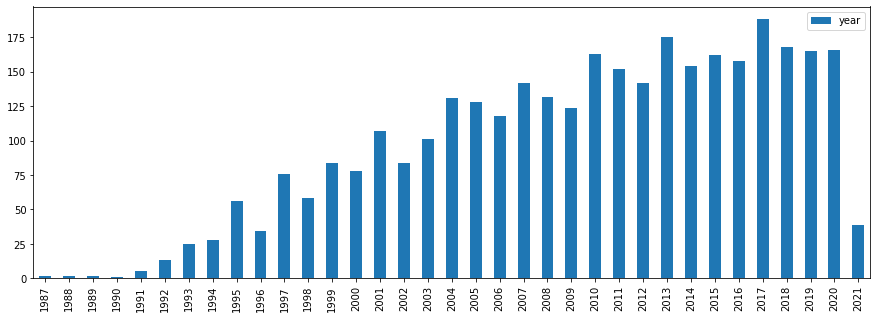

In [164]:
chrono.plot(kind="bar", figsize=(15, 5))

Top 20 journals citing GAP.

In [19]:
top_journals = bib_df['journal'].value_counts()

In [20]:
top_20 = pd.DataFrame(top_journals.head(20))
top_20.reset_index()

,index,journal
0,J. Algebra,387
1,Comm. Algebra,207
2,J. Symbolic Comput.,104
3,Discrete Math.,88
4,J. Algebra Appl.,85
5,J. Group Theory,67
6,J. Pure Appl. Algebra,64
7,Internat. J. Algebra Comput.,64
8,Des. Codes Cryptogr.,59
9,LMS J. Comput. Math.,47


Only for alternative, useful for copy/paste plain text - quick to load.
Try to allign on the left - journals.

In [21]:
headers = ['Journal name', 'GAP Citations count']
print(tabulate(top_20, headers = headers, tablefmt = 'pretty'))

+------------------------------+---------------------+
|         Journal name         | GAP Citations count |
+------------------------------+---------------------+
|          J. Algebra          |         387         |
|        Comm. Algebra         |         207         |
|     J. Symbolic Comput.      |         104         |
|        Discrete Math.        |         88          |
|       J. Algebra Appl.       |         85          |
|       J. Group Theory        |         67          |
|    J. Pure Appl. Algebra     |         64          |
| Internat. J. Algebra Comput. |         64          |
|     Des. Codes Cryptogr.     |         59          |
|     LMS J. Comput. Math.     |         47          |
|     Arch. Math. (Basel)      |         44          |
|      Experiment. Math.       |         42          |
|     European J. Combin.      |         42          |
|         Math. Comp.          |         37          |
|       Algebra Colloq.        |         35          |
|     Elec

In [22]:
bib_df['ENTRYTYPE'].describe()

count        3367
unique         10
top       article
freq         2976
Name: ENTRYTYPE, dtype: object

In [23]:
bib_df['ENTRYTYPE'].value_counts()

article          2976
incollection      204
inproceedings      54
phdthesis          47
mastersthesis      46
book               31
misc                5
techreport          2
inbook              1
manual              1
Name: ENTRYTYPE, dtype: int64

##### The most frequent type of work citing GAP: we can see that GAP is predominantly cited in articles - 2976 times.

In [183]:
types_pub = pd.DataFrame(bib_df['ENTRYTYPE'].value_counts())
types_pub.columns = ['GAP Citations Count']
types_pub.index.names = ['Publication Type']
types_pub

,GAP Citations Count
Publication Type,
article,2976
incollection,204
inproceedings,54
phdthesis,47
mastersthesis,46
book,31
misc,5
techreport,2
inbook,1


In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
interact(f, x=['apples','oranges']);

### Top 20 authors citing GAP in their work

<AxesSubplot:>

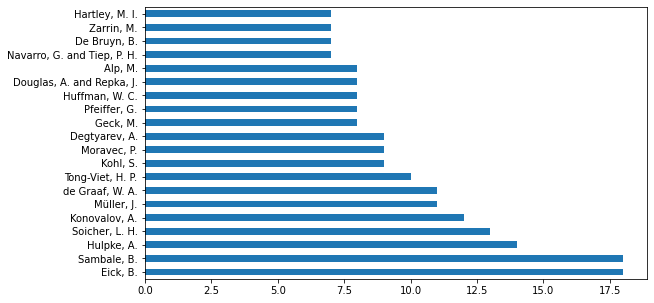

In [26]:
authors = bib_df['author'].value_counts()
top = authors.head(20)
#top.sort_values(ascending=True)
top.plot(kind="barh", figsize=(9,5))

#  Corpus and Review

What are the GAP Citation practices ???
The longer the citation is the more details it contains - measure lenght ?

To do
+ check Citations strings lenghts to isolate too short ones
+ version
+ website
+ remaining HTML characters

Two citations containing Singapore instead of GAP present.



In [27]:
corpus_df

,MR,Citation
0,MR4056124,"GAP – Groups, algorithms, programming - a syst..."
1,MR3942387,"Delgado, M., García-Sánchez, P.A., Morais, J.:..."
2,MR3942387,"The GAP Group: GAP—groups, algorithms, and pro..."
3,MR3354065,"The GAP – Groups, Algorithms and Programming. ..."
4,MR3646312,"The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Alg..."
...,...,...
3537,MR3988630,"M. Delgado, P. A. García-Sánchez and J. Morais..."
3538,MR1801202,"L.H. Soicher, GRAPE: a system for computing wi..."
3539,MR2558870,"L. Bartholdi, Functionally recursive groups, h..."
3540,MR2824780,"X. Sun, C. Liu, D. Li and J. Gao, On duality g..."


In [145]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf

def get_citation(mrno):
    r = corpus_df[corpus_df['MR'] == mrno]
    return r.at[r.index[0],'Citation'], r.at[r.index[0],'Version']
# r = corpus_df[corpus_df['MR'] == mrno]
# return [r.at[r.index[0],'Citation'], r.at[r.index[0],'Version']]

In [146]:
get_citation('MR1801202')

('L.H. Soicher, GRAPE: a system for computing with graphs and groups, in: L. Finkelstein and W.M. Kantor, eds., Groups and Computation, DIMACS Series in Discrete Mathematics and Theoretical Computer Science Vol. 11, AMS, (1993) pp. 287–291. GRAPE is available from http://www-gap.dcs.st-and.ac.uk/gap/Share/grape.html. \nMR1235810',
 'GRAPE GAP Package')

In [54]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf
unknown_ver = []
def get_version(s):
    match = re.search("(?:(\d+\.(?:\d+\.)*\d+))", s, re.IGNORECASE)
    if match != None:
        return match.group(1)
    else:
        print('No match:', s)
        unknown_ver.append(s)

In [55]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf
def is_package(series):
    mrno = series['MR']
    citation = series['Citation']
    version = series['Version']
    if re.search("package", citation, re.IGNORECASE) != None:
        print('***Package***:', mrno, citation)
        return 'Package'
# this way we catch cases where GRAPE is used without the word package
    elif re.search("grape", citation, re.IGNORECASE) != None: 
        print('??? GRAPE PKG ???:', mrno, citation)
        return 'GRAPE GAP Package'
    else:
        print('***Not a Package***:', mrno, citation)
        return series['Version']

First we create the version column.

In [31]:
corpus_df.insert(loc=2, column='Version', value=' ')

In [32]:
corpus_df['Version'] = corpus_df['Citation'].map(get_version)

No match: GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.
No match: Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 
MR3493240
No match: M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fifth ed., 1995.)
No match: W. Nickel, NQ, 1998, A refereed GAP 4 package, see [10].
No match: W. Nickel, NQ, 1998, A refereed GAP 4 package, see [8].
No match: Gamble, G., Nickel, W., O'Brien, E.A.: ANU p-Quotient–p-Quotient and p-Group Generation Algorithms (2006). An accepted GAP 4 package, available also in MAGMA
No match: M. Schönert et al, GAP: groups, algorithm and programming, © 1992 by Lehrstuhl D für Mathematik, distributed with the GAP software via ftp from samson.math.rwth-aachen.de.
No match: M. Delgado, P. A. G

No match: The GAP Group. GAP-Groups, Algorithms, and Programming, Version 4, 2005 (http://www.gap-system.org)
No match: GAP - Groups, algorithms, programming - a system for computational discrete algebra. http://www.gap-system.org/. Accessed 24 Jan 2019
No match: The GAP Group, GAP-4—Groups, Algorithms and Programming, Version 4, 2005.
No match: The GAP Group, Aachen, St. Andrews, GAP - Groups, Algorithms, and Programming, Version 4, 1998, (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
No match: GAP - Groups, Algorithms and Programming, Version 4, The GAP Group, Lehrstuhl D für Mathematik, RWTH Aachen, Germany and School of Mathematical and Computational Sciences, University of St. Andrews, Scotland. http://www. gap-system.org.
No match: Aichinger, E., Binder, F., Ecker, J., Eggetsberger, R., Mayr, P., Nöbauer, C. (2000). SONATA: Systems of Nearrings and Their Applications, Package for the group theory system GAP4, Austria, Universität Linz. Available at http://www.algebra.uni-linz.ac.at

No match: M. Schönert et. al., GAP Groups, Algorithms, and Programming, 5th edn., Lehrstuhl D Math., Rheinisch Westfällische Techn. Hochsch., Aachen, (1995).
No match: A. S. Detinko, A new GAP group library for irreducible maximal solvable subgroups of prime degree classical groups, J. Math. Sci. 108 (2002), 942–950. 
MR1747822
No match: A.S. Detinko, B. Eick, D.L. Flannery, Nilmat - Computing with nilpotent matrix groups. A refereed GAP 4 package, see http://www.gap-system.org/Packages/nilmat.html, 2007.
No match: Assmann, B., Eick, B., 2007a. Polenta-Polycyclic presentations for matrix groups. A refereed GAP 4 package. See http://www.gap-system.org/Packages/polenta.html.
No match: Detinko, A.S., Eick, B., Flannery, D.L., 2007. Nilmat-Computing with nilpotent matrix groups. A refereed GAP 4 package. See http://www.gap-system.org/Packages/nilmat.html.
No match: Detinko, A.S., Eick, B., Flannery, D.L., 2007. Nilmat–Computing with nilpotent matrix groups. A refereed GAP 4 package; see ht

No match: T. Breuer, The GAP character table library. http://www.math.rwth-aachen.de/~Thomas.Breuer/ctbllib/index.html
No match: J. Michel, The development version of the CHEVIE package of GAP3, J. Algebra 435 (2015), pp. 308–336. 
MR3343221
No match: M. Geck, ChevLie — constructing Lie algebras and Chevalley groups in GAP, available at http://www.math.rwth-aachen.de/~CHEVIE/contrib.html, July 2016.
No match: J. Michel, The development version of the CHEVIE package of GAP3, J. Algebra 435 (2015) 308–336, Webpage at https://webusers.imj-prg.fr/~jean.michel/chevie/chevie.html. 
MR3343221
No match: Computer program GAP, available from http://www-gap.dcs.st-andrews.ac.uk/$\sim$gap/
No match: S. P. Glasby, Supporting $\ssf{GAP}$ and Magma code, http://www.maths.uwa.edu.au/~glasby/RESEARCH.
No match: M. SCHO NERT et al., `GAP: groups, algorithms, and programming', RWTH Aachen, 1992.
No match: M. Schönert et al., "GAP: Groups, Algorithms, and Programming," RWTH, Aachen, 1992.
No match: The GA

No match: The GAP Group, Gap—groups, algorithms, and programming, Version 4b5, University of St Andrews and RWTH Aachen, 1998.
No match: A. Dooms, E. Jespers, A. Konovalov and H. Verrill, Congruence—congruence subgroups of $\roman {SL}_{2}(\Bbb {Z})$, GAP package.
No match: GAP, `Groups, algorithms, programming—a system for computational discrete algebra', http://www.gap-system.org.
No match: Gábor P. Nagy and Petr Vojtěchovský, LOOPS: A Package for GAP 4, beta version available at http://www.math.du.edu/loops
No match: G. P. Nagy and P. Vojtěchovský, LOOPS, Package for GAP 4 (2006), http://www.math.du.edu/loops.
No match: The GAP Team, "GAP—Groups, Algorithms, and Programming," Lehrstuhl D für Mathematik, RWTH Aachen and School of Mathematical and Computational Sciences, Univ. St. Andrews, Scotland, 1997.
No match: M. Schönert et al., GAP—Groups, algorithms, and programming, 5th ed., Lehrstuhl D für Mathematik, Rheinisch-Westfälische Technische Hochschule, Aachen, Germany, 1995.
No ma

No match: The GAP Group, GAP—Groups, Algorithms, and Programming, http://www.gap-system.org.
No match: GAP Group, GAP—Groups, algorithms, programming (2013) Available at http://www.gap-system.org
No match: M. Schönert et al., `GAP - Groups, algorithms and programming', RWTH Aachen: Lehrstuhl D für Mathematik, 5th edn, 1995 (http://www.gap.dsc.st-and.ac.uk/gap).
No match: `GAP—groups, algorithms, programming—a system for computational discrete algebra', http://www.gap-system.org/.
No match: Ellis, G. (2010). HAP-Homological Algebra Programming. A refreed GAP 4 package (GAP Group 2008), available at http://hamilton.nuigalway.ie/Hap/www. 
MR2478414
No match: G. Ellis, HAP-Homological Algebra Programming (2010), A refreed GAP 4 package (GAP Group 2008), available at http://hamilton.nuigalway.ie/Hap/www. 
MR2478414
No match: Schönert, M. et al. (1993). GAP—Groups, Algorithms and Programming. Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, $3^{\roman{rd}}$ edn, Aach

No match: Linton, S. G., Pfeiffer, G., Robertson, E., Ruskuc, N. (1997). Gap package. PC Software.
No match: http://www-gap.dcs.st-and.ac.uk/$\sim$gap/.
No match: M. Delgado, P. A. García-Sánchez and J. Morais, "numericalsgps": a gap package on numerical semigroups; available at http://www.gap-system.org/Packages/numericalsgps.html.
No match: S. Kohl, A bound on the order of the outer automorphism group of a finite simple group of given order (2003), http://www.gap-system.org/DevelopersPages/StefanKohl/preprints/outbound.pdf. 
cf. MR1808358
No match: I. Abdeljaouad, Calculs d'invariants primitifs de groupes finis, Theor. Inform. Appl. 33(1) (1999) 59–77, http://www-gap.mcs.st-and.ac.uk/Gap3/Contrib3/contrib.html. 
MR1705856
No match: M. Delgado, P.A. García-Sánchez and J. Morais, "numericalsgps": A gap package on numerical semigroups, http://www.gap-system.org/Packages/numericalsgps.html.
No match: Gap software - groups, algorithms, programming - a system for computational discrete alg

In [33]:
corpus_df['Version'].value_counts()

4.4        460
4.4.12     310
4.3        232
4.4.10     136
4.2        127
          ... 
1.7          1
4.46         1
2.4.3        1
4.08.10      1
2.1.3        1
Name: Version, Length: 196, dtype: int64

Then we apply the function which chekcs if it is a case of citing GAP Package. Packages are connected to GAP, but technically is a separate piece of software.

In [34]:
corpus_df['Version'] = corpus_df.apply(is_package,axis=1)

***Not a Package***: MR4056124 GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.
***Package***: MR3942387 Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 
MR3493240
***Not a Package***: MR3942387 The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017
***Not a Package***: MR3354065 The GAP – Groups, Algorithms and Programming. Version 4.4.12, 2008. www.gap-system.org.
***Not a Package***: MR3646312 The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Algorithms, and Programming, 4.7.8, 2015, http://www.gap-system.org.
***Not a Package***: MR1864795 M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fifth ed., 1995.)
***Not a Package***: MR2287843 The G

***Not a Package***: MR2401559 The GAP group, GAP, Aachen, St. Andrews, http:www-gap.dcs.st-and.ac.uk/gap, 1999.
***Not a Package***: MR2303162 The GAP Group, GAP—Groups, Algorithms and Programming, Version 4.3, Aachen, St Andrews, 2003, <http://www.gap-system.org>.
***Not a Package***: MR2404644 The GAP Group, GAP - Groups, Algorithms and Programming, Version 4.2, Aachen, St. Andrews, 2000, (http://www-gap.dcs.st-and.ac.uk/-gap).
***Not a Package***: MR2660431 The GAP Group, GAP — Groups, Algorithms and Programming (Version 4.2), Aachen, St Andrews, 2000 (http://www-gap.dcs.st-and.ac.uk/~gap).
***Not a Package***: MR2923663 The GAP Group, $\Bbb{GAP}$ - Groups, Algorithms and Programming, Version 4.3, Aachen, St Andrews, 2002, (http://www.gap-system.org).
***Not a Package***: MR3293591 The GAP Group, $\Bbb{G}\Bbb{A}\Bbb{P}$ - Groups, Algorithms and Programming, Version 4.3, Aachen, St. Andrews, 2003, (http://www.gap-system.org).
***Not a Package***: MR3943349 F. Ali, M. Al-Kadhi, A. Al

***Package***: MR2745541 R.A. Wilson, R.A. Parker, S. Nickerson, J.N. Bray, T. Breuer, AtlasRep, A GAP Interface to the ATLAS of Group Representations, Version 1.4, 2007, refereed GAP package. http://www.math.rwth-aachen.de/$\sim$Thomas.Breuer/atlasrep.
***Not a Package***: MR3908852 The GAP Group: GAP—Groups, Algorithms and Programming. Version 4.4.12 (2008). http://www.gap-system.org
***Not a Package***: MR4050668 The GAP Group, GAP – groups, algorithms and programming, Version 4.9.3, 2018, http://www.gap-system.org.
***Not a Package***: MR3963087 The GAP Group. (2018). GAP groups, algorithms and programming, version 4.9.3. http://www.gap-system.org.
***Not a Package***: MR2862555 The GAP Group, GAP - Groups, Algorithms and Programming, Version 4.4, 2004.
***Package***: MR2862555 M. Neunhöffer, Á. Seress, GAP Package "recogbase", http://www-groups.mcs.st-and.ac.uk/$\sim$neunhoef/ Computer/Software/Gap/recogbase.html.
***Package***: MR2862555 M. Neunhöffer, Á. Seress, GAP Package "rec

***Package***: MR3658506 A. Bächle and L. Margolis, HeLP – A GAP package for torsion units in integral group rings, preprint (2015), arXiv:1507.08174 [math.RT]. 
MR3820369
***Package***: MR3658506 A. Bächle and L. Margolis, HeLP – Hertweck–Luthar–Passi method, GAP package, Version 2.1 (2015), http://homepages.vub.ac.be/abachle/help/. 
MR3820369
***Not a Package***: MR3658506 The GAP Group, GAP — Groups, Algorithms, and Programming (2015). Version 4.7.8, http://www.gap-system.org.
***Package***: MR3708050 A. Bächle and L. Margolis, HeLP – A GAP package for torsion units in integral group rings, submitted, preprint (2015), arXiv:1507.08174 [math.RT]. 
MR3820369
***Package***: MR3708050 A. Bächle and L. Margolis, HeLP – Hertweck–Luthar–Passi method, GAP package, Version 2.2, http://homepages.vub.ac.be/abachle/help/(2015).
***Package***: MR3708050 T. Breuer, The GAP Character Table Library, Version 1.2.1, http://www.math.rwthaachen.de/~Thomas.Breuer/ctbllib, May (2012), GAP package.
***Not

***Package***: MR3917961 Delgado, M., García-Sánchez, P.A., Morais, J.: "NumericalSgps"—a GAP package, Version 1.1.5. http://www.gap-system.org/Packages/numericalsgps.html. Accessed 25 Sept 2017
***Not a Package***: MR3917961 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.8.4 (2016). http://www.gap-system.org. Accessed 4 June 2016
***Not a Package***: MR3483355 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4.10, 2007. http://www.gap-system.org
***Not a Package***: MR3622353 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4.10, 2007. http://www.gap-system.org
***Not a Package***: MR3145212 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4.10; 2007. (http://www.gap-system.org)
***Not a Package***: MR3345535 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4.10; 2007. (http://www.gap-system.org)
***Not a Package***: MR3885655 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4

***Not a Package***: MR2103323 M. Schönert et al. GAP - Groups, Algorithms, and Programming. Lehrstuhl D für Mathematik, RWTH, Aachen, Germany, fourth edition, 1994.
***Package***: MR2171593 D. Bessis and J. Michel, VKCURVE, software package for $\roman{GAP}3$, source and documentation available at: http://www.math.jussieu.fr/ jmichel/vkcurve.html
***Not a Package***: MR2544289 The GAP Group. GAP-Groups, Algorithms, and Programming, Version 4, 2005 (http://www.gap-system.org)
***Package***: MR3883809 Bamberg, J., Betten, A., Cara, Ph., De Beule, J., Lavrauw, M., Neunhöffer, M.: Finite Incidence Geometry. FinInG - a GAP package, version 1.4 (2017)
***Not a Package***: MR3883809 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.8.10 (2018). https://www.gap-system.org
***Not a Package***: MR3976189 GAP - Groups, algorithms, programming - a system for computational discrete algebra. http://www.gap-system.org/. Accessed 24 Jan 2019
***Not a Package***: MR2228637 The GAP Gr

***Not a Package***: MR1871679 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.1; Aachen, St. Andrews, 1999. (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
***Not a Package***: MR1925146 The GAP group, The GAP4 Reference Manual, St. Andrews and Aachen, 1998.
***Not a Package***: MR3227979 The GAP Group, GAP—groups, algorithms, and programming, version 4.7.4; 2014. (http://www.gap-system.org).
***Not a Package***: MR3897218 The GAP Group. GAP - Groups, Algorithms, and Programming, Version 4.9.1, 2018. https://www.gap-system.org.
***Not a Package***: MR4148294 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.10.2, https://www.gap-system.org, 2019.
***Not a Package***: MR2378037 The GAP Group, GAP—groups, algorithms, and programming, Version 4.3, 2003 (http://www.gap-system.org).
***Not a Package***: MR2679555 The GAP Group, GAP–groups, algorithms, and programming, Version 4.4.10, 2007 (http://www.gap-system.org)
***Not a Package***: MR2293591 The GAP Gr

***Not a Package***: MR2669683 The GAP group, '`GAP—groups, algorithms and programming, version 4.4', 2005, http://www.gapsystem.org.
***Not a Package***: MR3682588 T. Breuer, The $\ssf{GAP}$ Character Table Library, Version 1.2.2; 2013, http://www.math.rwth-aachen.de/~Thomas.Breuer/ctbllib.
***Not a Package***: MR3682588 The GAP Group, $\ssf{GAP}$ – Groups, Algorithms, and Programming, Version 4.7.7; 2015, http://www.gap-system.org.
***Not a Package***: MR3682588 R. A. Wilson et al., $\ssf{AtlasRep}$, a $\ssf{GAP}$ Interface to the Atlas of Group Representations, Version 1.5.1; 2016, http://www.math.rwth-aachen.de/~Thomas.Breuer/atlasrep.
***Package***: MR3985485 T. Breuer, CTblLib, The GAP Character Table Library, a GAP package, Version 1.2.2 (released 07/03/2013), http://www.gap-system.org/Packages/ctbllib.html, http://www.math.rwth-aachen.de/~Thomas.Breuer/ctbllib/.
***Not a Package***: MR3985485 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.9.2; 2018, https:/

***Not a Package***: MR3007647 The GAP Group, GAP—groups, algorithms, and programming, version 4.4.12, Preprint, 2008, http://www.gap-system.org.
***Not a Package***: MR3483179 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.7.5. (2014) http://www.gap-system.org
***Not a Package***: MR2684423 T. Breuer, Manual for the GAP Character Table Library, Version 1.1, RWTH Aachen, 2004.
***Not a Package***: MR2684423 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4, 2004.
***Package***: MR2684423 J. Müller, M. Neunhöffer and F. Noeske, GAP 4 Package orb, http://www.math.rwth-aachen.de/$\sim$Max.Neunhoeffer/Computer/ Software/Gap/orb.html.
***Not a Package***: MR3219555 T. Breuer, Manual for the GAP Character Table Library, Version 1.1, RWTH Aachen, 2004.
***Not a Package***: MR3219555 T. Breuer, GAP Computations with ${O^ + }(8,5).{S_3}$ and ${O^ + }(8,2).{S_3}$, RWTH Aachen, 2006; http://www.math.rwth-aachen.de/$\sim$Thomas.Breuer/ctbllib/htm/o8p2s3\_o8p5

***Not a Package***: MR2506729 The GAP Group.: GAP-Groups, Algorithms, and Programming, Version 4.4. (2005). (http://www.gap-system.org).
***Not a Package***: MR2007467 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.2, 2000 (http://www.gap-system.org).
***Not a Package***: MR2255131 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2004.
***Not a Package***: MR4053064 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.9.2, https://www.gap-system.org, 2018.
***Not a Package***: MR2291618 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.2, 2000, http://www.gap-system.org.
***Not a Package***: MR2402530 The GAP Group, Gap-groups, algorithms, and programming, version 4.4, 2005, (http://www.gap-system.org).
***Not a Package***: MR2438195 The GAP Group. GAP - Groups, Algorithms, and Programming, Version 4.4, 2005, (http://www.gap-system.org).
***Not a Package***: MR2228640 The GAP Group, GAP—Gr

***Not a Package***: MR3271175 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2005. (http://www.gap-system.org).
***Not a Package***: MR3449012 The GAP Group: GAP – Groups, Algorithms, and Programming, Version 4.4. (2005). The GAP Group. http://www.gap-system.org
***Not a Package***: MR3973105 GAP Group, "GAP—Groups, Algorithms, and Programming, Version 4.8.7." 2017, http://www.gap-system.o.
***Package***: MR2434096 The GAP group, `GAP—groups, algorithms, and programming, version 4.4', 2006, package Grape, http://www.gap-system.org
***Not a Package***: MR2242478 GAP—Groups, Algorithms and Programming, Version 4.3, 2002.
***Not a Package***: MR3879476 The GAP Group.: GAP - Groups, Algorithms, and Programming, Version 4.8.6 (2016). https://www.gap-system.org/
***Package***: MR3346170 GAP SmallGroups Library www.gap-system.org/Packages/sgl.html (accessed 18 December 2014)
***Not a Package***: MR3432870 The GAP Group, GAP — Groups, Algorithms, and Programming, Version

***Package***: MR2299793 V. Dabbaghian-Abdoly, RPSEN - A Package for Constructing Representations of Finite Groups, GAP Package, 2004, (http://www.gap-system.org/Packages/repsn.html). 
MR2168613
***Not a Package***: MR2299793 The GAP Group, GAP—Groups, Algorithms, and Programming. Version 4.6 (2005), (http://www.gap-system.org).
***Package***: MR2168613 Dabbaghian-Abdoly, V., 2004. RPSEN—A Package for Constructing Representations of Finite Groups. GAP Package. http://www.gap-system.org/Packages/repsn.html. 
MR2705116
***Not a Package***: MR2168613 The GAP Group, 2004. GAP—Groups, Algorithms, and Programming. Version 4.4. http://www.gap-system.org.
***Package***: MR2255125 V. Dabbaghian-Abdoly, RPSEN—A Package for Constructing Representations of Finite Groups, GAP Package, 2004, http://www.gap-system.org/Packages/repsn.html. 
MR2168613
***Package***: MR2303192 V. Dabbaghian-Abdoly, REPSN—A package for constructing representations of finite groups, GAP package, http://www.gap-system.org/

***Package***: MR3774427 Delgado, M., García-Sánchez, P.A., Morais, J.: "NumericalSgps", A $\ssf{GAP}$ Package for Numerical Semi-groups, Version 1.0.1 (2015). http://www.gap-system.org/ 
MR3493240
***Not a Package***: MR3774427 The GAP Group: GAP—groups, algorithms, and programming, Version 4.8.7 (2017). http://www.gap-system.org
***Not a Package***: MR2998799 The GAP Group, GAP - Groups, Algorithms and Programming, Version 4.5.6, http://www.gap-system.org, 2012.
***Not a Package***: MR3606589 The GAP Group. GAP – Groups, algorithms, and programming. 2015. Available from: http://www.gap-system.org.
***Not a Package***: MR2166140 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4, 2004, http://www.gap-system.org.
***Not a Package***: MR2846397 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2006.
***Not a Package***: MR3937764 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.10, https://www.gap-syst

***Not a Package***: MR4180114 The GAP Group, 2019. GAP – groups, algorithms, and programming. Available at gap-system.org.
***Not a Package***: MR4193502 H. Dietrich and D. Low, GAP code to work with C-groups, github.com/heikodietrich/cgroups.
***Not a Package***: MR4193502 GAP – Groups, Algorithms and Programming, available at gap-system.org.
***Not a Package***: MR4090490 GAP—Groups, Algorithms, and Programming. Version 4-10-0. gap-system.org
***Not a Package***: MR4187252 The GAP Group, GAP – groups, algorithms, and programming, available at gap-system.org.
***Not a Package***: MR2981138 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.3; 2002, http://www.gap-system.org.
***Package***: MR3187647 J. Michel, The development version of the CHEVIE package of GAP3, arXiv:1310.7905. 
cf. MR3343221
***Not a Package***: MR2397403 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.9; http://www.gap-system.org, 2006.
***Not a Package***: MR2535999 The GAP 

***Not a Package***: MR3228937 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2006, http://www.gap-system.org.
***Not a Package***: MR3357522 The GAP Group, GAP – Groups, Algorithms, and Programming, (Version 4.7.5) (2014) http://www.gap-system.org.
***Not a Package***: MR2442053 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.9, http://www.gap-system.org, 2006.
***Package***: MR3414409 J. Michel, The development version of the CHEVIE package of GAP3, Preprint, arXiv:1310.7905, 2013. 
cf. MR3343221
***Not a Package***: MR3085035 J. Michel, Development version of the GAP part of CHEVIE, http://www.institut.math.jussieu.fr/$\sim$jmichel/chevie/chevie.html.
***Package***: MR3210126 J. Michel, The GAP-part of the Chevie system, GAP 3-package available for download from http://www.math.jussieu.fr/$\sim$jmichel/chevie/chevie.html.
***Package***: MR1840386 Dumas, J.-G., Heckenbach, F., Saunders, B. D., Welker, V. (2000). Simplicial Homology, a (propos

***Not a Package***: MR2655290 The $\ssf{GAP}$ Group, $\ssf{GAP}$ - Groups, Algorithms and Programming, Version 4.4 (2005), available at http://www.gap-system.org.
***Package***: MR3498299 V. Felsch and F. Gähler, CrystCap – A libarary of crystallographic groups. A refereed GAP 4 package, 2000.
***Not a Package***: MR3498299 The GAP Group, GAP–Groups, Algorithms and Programming, Version 4.4, 2005, http://www.gap-system.org.
***Not a Package***: MR3641681 The GAP Group, GAP – Groups, Algorithms and Programming, Version 4.4, available from http://www.gap-system.org, 2005.
***Not a Package***: MR3780008 The GAP Group, GAP – Groups, Algorithms and Programming, Version 4.4. Available from http://www.gap-system.org, 2005.
***Package***: MR3807061 H.U. Besche, B. Eick, E. O'Brien, Small Groups – a library of groups of small order. A GAP 4 package. Webpage available at www.icm.tu-bs.de/ag_algebra/software/small/small.html, 2005.
***Package***: MR3807061 B. Eick, T. Moede, pnqporc, a GAP 4 pack

***Not a Package***: MR2959430 The GAP Group, GAP-Groups, Algorithms and Programming, Version 4.4.12 (2008) (http://www.gap-system.org/).
***Not a Package***: MR2998958 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.12, 2008, URL http://www.gap-system.org.
***Not a Package***: MR3500766 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.6.3, http://www.gapsystem.org, 2013.
***Package***: MR3500766 L. Maas, SpinSym – a GAP package, Version 1.5, http://www.uni-due.de/~s400304/spinsym/, 2013.
***Package***: MR3500766 J. Müller, M. Neunhöffer, F. Noeske, Orb – a GAP 4 package, Version 4.7.3, http://gap-system.github.io/orb/, 2014.
***Not a Package***: MR3780414 The GAP Group, GAP – Groups, Algorithms, and Programming, version 4.8.3, http://www.gap-system.org, 2016.
***Package***: MR3780414 R.A. Wilson, R.A. Parker, S. Nickerson, J.N. Bray, T. Breuer, AtlasRep, a GAP interface to the Atlas of Group Representations, version 1.5, http://www.gap-system.o

***Not a Package***: MR3108775 The GAP Group, GAP - Groups, Algorithms, and Programming, version 4.5.6, (2012) http://www.gap-system.org.
***Package***: MR3108775 G. Ellis, HAP (Homological Algebra Programming) - a GAP package, version 1.10.8, (2012); http://www.gap-system.org/Packages/hap.html.
***Not a Package***: MR3409788 The GAP Group, "GAP-Groups, Algorithms, and Programming, version 4.5.6," (2012) http://www.gap-system.org.
***Not a Package***: MR4192835 The GAP Group, GAP – groups, algorithms, and programming, version 4.7.7, http://www.gap-system.org, 2015.
***Not a Package***: MR2997021 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4.12, 2008, http://www.gap-system.org.
***Not a Package***: MR3071138 The GAP Group, GAP–Groups, Algorithms and Programming, version 4.4.12 (2008) Available at http://www.gap-system.org/
***Not a Package***: MR3320497 A. Hulpke, Transitive permutation groups - A GAP data library www.gap-system.org/Datalib/trans.html.
***Not a Pac

***Not a Package***: MR2726571 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.10 (system.org, 2003, http://www.gap).
***Not a Package***: MR3063455 The GAP Group, GAP-Groups, Algorithms and Programming, version 4.4 (2006), http:/www.gap-system.org.
***Not a Package***: MR3393942 GAP Group, GAP – Groups, Algorithms and Programming, version 4.4, (2006) http://www.gap-system.org.
***Not a Package***: MR3616188 The GAP Group, GAP-Groups, Algorithms and Programming, version 4.4 2006 (system.org) (http:/www.gap).
***Not a Package***: MR3488232 The GAP Group, GAP-Groups, Algorithms and Programming, version 4.4 2006. (http://www.gapsystem.org)
***Not a Package***: MR3471269 The GAP Group, GAP—groups, algorithms, and programming, Version 4.7.4, 2014, http://www.gap-system.org.
***Not a Package***: MR3800846 The GAP Group, http://www.gap-system.org: GAP – Groups, Algorithms, and Programming, Version 4.7.4, 2014.
***Not a Package***: MR3341523 The GAP Group, GAP – Groups, Alg

***Not a Package***: MR2745544 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4.12, 2008, http://www.gap-system.org.
***Not a Package***: MR2824526 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.12, 2008, http://www.gap-system.org.
***Not a Package***: MR1751922 Martin Schönert and OTHERS, GAP - groups, algorithms, and programming, 5th edn (Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, 1995). Available from the Department of Computer Science, University of St. Andrews, http://www-gap.dcs.st-and.ac.uk/ gap/. 111
***Not a Package***: MR3196069 The GAP Group (2008). Groups, Algorithms, and Programming, Available at http://www.gap-system.org (2008). Accessed January 2, 2013.
***Not a Package***: MR3225618 The GAP Group, Groups, Algorithms, and Programming, http://www.gap-system.org (2008).
***Not a Package***: MR3582856 The GAP Group (2008). Groups, algorithms, and programming. Available at: http://www.gap

***Not a Package***: MR2077414 The GAP Group: GAP–Groups, Algorithms, and Programming. Version 4.3. http://www.gap-system.org (2002)
***Not a Package***: MR2433003 The GAP Group: GAP - Groups, Algorithms, and Programming, Version 4.4; http://www.gap-system.org (2005).
***Not a Package***: MR2475016 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3. http://www.gap-system.org, 2002.
***Not a Package***: MR2728036 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.4, http://www. gap-system.org (2005)
***Not a Package***: MR2791293 The GAP Group, Gap–Groups, Algorithms, and Programming, version 4.4, 2005, http://www.gap-system.org.
***Not a Package***: MR2807030 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4. http://www.gap-system.org+ (2005)
***Not a Package***: MR2286467 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2005.
***Not a Package***: MR4044456 The GAP Group, GAP – Groups, Al

***Not a Package***: MR3366593 The GAP-Group. (2012). GAP – Groups, Algorithms and Programming. Version 4.5.7, http://www.gap-system.org.
***Not a Package***: MR3924767 The GAP Group. (2017). GAP – Groups, Algorithms, and Programming, Version 4.8.9; (https://www.gap-system.org).
***Not a Package***: MR2422311 The GAP Group, GAP—Groups, Algorithms and Programming, Version 4.4.9, Aachen, St. Andrews, http://www.gap-system.org, 2006.
***Not a Package***: MR3818299 The GAP Group, GAP – groups, algorithms, and programming, version 4.7.9, http://www.gap-system.org, 2015.
***Not a Package***: MR1673415 M. Schönert et al., GAP, version 3.4, 4th edn (D für Mathematik, RWTH Aachen, 1995).
***Not a Package***: MR3182982 The GAP Group, GAP—Groups, Algorithms, and Programming, version 4.6.5, http://www.gapsystem.org, 2013.
***Not a Package***: MR2098793 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, http://www.gap-system.org, 2002.
***Not a Package***: MR2486631 The GAP Group,

***Package***: MR2332495 J. Cramwinckel, et al., GUAVA A GAP 4 Package for Computing with Error-Correcting Codes, http://cadigweb.ew.usna.edu/$\sim$wdj/gap/GUAVA/.
***Not a Package***: MR2516425 I.M. Araújo, and 50 co-authors, GAP Reference Manual, The GAP Group, http://www.gap-system.org.
***Package***: MR2516425 J. Cramwinckel, E. Roijackers, R. Baart, E. Minkes, L. Ruscio, C. Tjhai, D. Joyner, GUAVA A GAP4 package for computing with error-correcting codes, http://cadigweb.ew.usna.edu/$\sim$wdj/gap/GUAVA/.
***Not a Package***: MR3034304 I. M. Araújo, et al., GAP reference manual, The GAP Group, http://www.gap-system.org
***Not a Package***: MR3092314 I. M. Araújo, et al., GAP Reference Manual, The GAP Group, http://www.gap-system.org
***Not a Package***: MR1659847 The GAP Group, School of Mathematical and Computational Sciences, University of St Andrews, and Lehrstuhl D fur Mathematik, RWTH Aachen, GAP - Groups, Algorithms, and Programming, Version 4, 1998.
***Not a Package***: MR191

***Not a Package***: MR2153793 The GAP Group, `GAP - groups, algorithms, and programming', Version 4.4, 2004, http://www.gap-system.org. 125, 126, 128, 133, 134, 135, 136, 141
***Not a Package***: MR2724218 The GAP Group. (2004). GAP–Groups, Algorithms, and Programming. Version 4.4. http://www.gap-system.org.
***Package***: MR2724218 Nagy, G. P., Vojtěchovský, P. LOOPS: Computing with Quasigroups and Loops. Version 2.0.0. Package for GAP, http://www.math.du.edu/loops.
***Not a Package***: MR2859875 GAP Group, GAP - Groups, algorithms, and programming, version 4.4.10, 2007, http://www.gap-system.org.
***Package***: MR2859875 G. Nagy, P. Vojtěchovský, LOOPS: Computing with quasigroups and loops in GAP - a GAP package, version 2.0.0, 2008, http://www.math.du.edu/loops. 
MR2379126
***Not a Package***: MR3400403 The GAP Group, GAP – groups, algorithms, and programming, version 4.5.5, available at http://www.gap-system.org, 2012.
***Not a Package***: MR3584827 The GAP Group, GAP–Groups, Algo

***Not a Package***: MR4109154 GAP. GAP - Groups, Algorithms, and Programming, Version 4.8.4. http://www.gap-system.org (2016)
***Package***: MR2869050 Polyhedral – a GAP package, by M. Dutour Sikirić, http://www.liga.ens.fr/~dutour/Polyhedral/index.html.
***Not a Package***: MR1842506 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.1. Aachen, St Andrews, 1999; http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
***Not a Package***: MR2072003 The GAP Group, GAP—Groups, Algorithms and Programming, Version 4.3, 2002 (http://www.gap-system.org)
***Not a Package***: MR2206400 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4, 2004, http://www.gap-system.org.
***Not a Package***: MR2127688 GAP, Groups, Algorithms and Programming, Version 4–3. The GAP Group, Lehrstuhl D für Mathematik, RWTH Aachen, Germany and School of Mathematical and Computational Sciences, University of St. Andrews, Scotland, http://www-gap.dcs.st-and.ac.uk/$\sim$gap/ 2002.
***Not a Package***:

***Package***: MR2651342 T. Breuer, GAP4-package CTblLib—The GAP Character Table Library, Version 1.1.3, http://www.gap-system.org/Packages/ctbllib.html, 2004.
***Not a Package***: MR2651342 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.12, http://www.gap-system.org, 2008.
***Package***: MR2651342 R. Wilson, R. Parker, S. Nickerson, J. Bray, T. Breuer, GAP4-package AtlasRep—A GAP Interface to the Atlas of Group Representations, Version 1.4.0, http://www.gap-system.org/Packages/atlasrep.html, 2008.
***Package***: MR2852247 T. Breuer, GAP package CTblLib—The GAP Character Table Library, Version 1.1.3, http://www.gap-system.org/Packages/ctbllib.html.
***Not a Package***: MR2852247 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.12, http://www.gap-system.org.
***Package***: MR2852247 R. Wilson, R. Parker, S. Nickerson, J. Bray, T. Breuer, GAP package AtlasRep—A GAP Interface to the Atlas of Group Representations, Version 1.4.0, http://www.gap-syste

***Not a Package***: MR3169443 The GAP Group. GAP–Groups, Algorithms, and Programming. Version 4.4.12 of 17-Dec-2008. Available at http://www.gap-system.org. Accessed Feb 4, 2013.
***Package***: MR3863486 T. Breuer, CTblLib, – GAP's Character Table Library package, version 1.2.1, http://www.math.rwth-aachen.de/~Thomas.Breuer/ctbllib, 2012.
***Not a Package***: MR3863486 The GAP Group, GAP – Groups, Algorithms, and Programming, version 4.8.7, http://www.gap-system.org, 2017.
***Not a Package***: MR2333176 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2004.
***Not a Package***: MR2350989 The GAP Group, GAP—Groups, Algorithms, and Programming (Version 4.4; 2006), http://www.gap-system.org.
***Not a Package***: MR2333443 The GAP Group: GAP–Groups, Algorithms, and Programming. Version 4.4, http://www.gap-system.org (2006)
***Not a Package***: MR2489902 The GAP Group, GAP–groups, algorithms, and programming, version 4.4; http://www.gap-system

***Package***: MR3778224 K. Dekimpe and B. Eick, Aclib – a GAP package, Version 1.2 (2012), http://www.icm.tu-bs.de/beick/so.html.
***Not a Package***: MR3778224 GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.3 (2016), http://www.gap-system.org/.
***Not a Package***: MR1809429 M. Schönert et al., "GAP-Groups, Algorithms, and Programming," Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, fifth edition, 1995. Also available at http://www.math.rwth-aachen.de/$\sim$GAP/WWW/.
***Not a Package***: MR2410566 The GAP Group. GAP–Groups, Algorithms, and Programming, Version 4.4. http://www.gap-system.org, 2004.
***Not a Package***: MR1806213 Schönert, M. et al. (1994). GAP—Groups, Algorithms and Programming, 3.4 edn. Lehrstuhl D für Mathematik, RWTH Aachen.
***Not a Package***: MR2378074 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2006.
***Package***: MR2378074 J. Müller, M. Neunhöffer, F. Noe

***Not a Package***: MR4063323 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.9.2; 2018. (https://www.gap-system.org)
***Not a Package***: MR2823587 The GAP Group, GAP-Groups, Algorithms, and Programming (Version 4.4), 2005, http://www.gap-system.org.
***Not a Package***: MR1884468 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.1, Aachen, St. Andrews http://www.math.rwth-aachen.de/$\sim$GAP/, 1999.
***Not a Package***: MR2124813 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4 (2004); available at http://www.gap-system.org.
***Not a Package***: MR2802525 The GAP Group, GAP - Groups, Algorithms, and Programming, version 4.4.10, 2007. Available at http://www.gap-system.org
***Not a Package***: MR2087093 The GAP Group, GAP - Groups, algorithms, and programming, Version 4.3 (2002); http://www.gap-system.org. 102, 104
***Not a Package***: MR4022701 GAP — Groups, Algorithms, and Programming, Version 4.10.0. The GAP Group (2018), %5Cv

***Not a Package***: MR3508661 The GAP Group, GAP-Groups, Algorithms and Programming, Version 4.4.12, www.gap-system.org, 2008.
***Not a Package***: MR2228516 The GAP group, GAP-Groups, Algorithms, and Programming, Version 4.3, Aachen, St Andrews (2002) http://www.gap-system.org.
***Not a Package***: MR2441479 GAP, Groups, Algorithms and Programming, Version 4.3, 2002 (http://www.gap-system.org/).
***Not a Package***: MR3567881 The GAP Group, GAP-Groups, Algorithms and Programming. Version 4.7.5, 2014, http://www.gap-system.org/.
***Not a Package***: MR2845566 GAP. (2009). Groups, Algorithms, and Programming. Version 4.4.12. Available at www.gap-system.org.
***Not a Package***: MR3120054 Groups, Algorithms, and Programming (GAP), Version 4.4.12. http://www.gap-system.org (2009)
***Not a Package***: MR3770014 The GAP Group: GAP — Groups, Algorithms, and Programming. Version 4.8.7, released on 24 March 2017, http://www.gap-system.org.
***Not a Package***: MR3918480 The GAP Group: GAP — G

***Not a Package***: MR2515813 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4.9 ; 2006. http://www.gap-system.org.
***Not a Package***: MR2459358 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4. http://www.gap-system.org, 2004.
***Package***: MR2459358 G.P. Nagy, P. Vojtěchovský, LOOPS: Package for GAP, Version 0.99. http://www.math.du.edu/loops/, 2004.
***Not a Package***: MR2355056 The GAP Group, 2006. GAP—Groups, Algorithms, and Programming, Version 4.4; Aachen, St Andrews (Visit http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
***Not a Package***: MR2355056 Nagy, G.P., Vojtěchovský, P., 2007. LOOPS: Computing with quasigroups and loops in GAP, download at http://www.math.du.edu/loops. 
MR2379126
***Package***: MR3269010 Cicalò S., de Graaf W.A., Schneider C., LieAlgDB–a GAP package, Version 2.1, November 2010, http://www.gap-system.org/Packages/liealgdb.html.
***Not a Package***: MR3205815 GAP Group: GAP—Groups, Algorithms, and Programming, Ver

***Not a Package***: MR3331614 T G group, GAP: Groups, algorithms and programming (2008) Available at http://www.gap-system.org/
***Not a Package***: MR2511545 The GAP Group, GAP-Groups, Algorithms and Programming, Version 4.4.9 (2006). (http://www.gap-system.org).
***Not a Package***: MR1981041 The GAP Group, 2002. GAP—Groups, Algorithms, and Programming, version 4.3. Available from: http://www.gap-system.org.
***Package***: MR1981041 Olivieri, A., del Río, Á., wedderga, A GAP 4 package for computing central idempotents and simple components of rational group algebras (submitted).
***Not a Package***: MR2100373 The GAP Group, GAP—Groups, Algoritms, and Programming, Version 4.3; 2002 (http://www.gap-system.org).
***Package***: MR2100373 Olivieri, A. del Río, A. (2003a). wedderga. A GAP 4 package for computing central idempotents and simple components of rational group algebras.
***Not a Package***: MR2152754 GAP group. GAP—Groups, Algorithms, and Programming, Version 4, 1999.
***Packag

***Not a Package***: MR1176715 M. Schönert et al., GAP 3.1 manual, March 1992, Lehrstuhl D für Mathematik, RWTH Aachen.
***Not a Package***: MR2169521 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.2. Aachen, St Andrews, 1999. Also available from World Wide Web (http://www.gap-system.org).
***Not a Package***: MR3178247 The GAP Group, GAP - Groups, Algorithms, Programming - a System for Computational Discrete Algebra (http://www.gap-system.org/). Greene, C. Weight enumeration and the geometry of linear codes. Studies in Appl. Math. 55 (1976), no. 2, 119–128. 
MR0447020
***Not a Package***: MR3124646 GAP—Groups, Algorithms, and Programming The GAP Group, 2012, Version 4.5.4 [Online]. Available: http://www.gap-system.org
***Not a Package***: MR2660583 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.4. http://www.gap-system.org. (2006)
***Not a Package***: MR2498259 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4, http://www.gap-s

***Package***: MR2594680 D. F. Holt, B. Eick and E. O'Brien, GAP package kbmag, 2009, http://www.warwick.ac.uk/$\sim$mareg/kbmag.
***Not a Package***: MR2820156 The GAP Group, `GAP—groups, algorithms, and programming', version 4.4.12, 2008, http://www.gap-system.org.
***Package***: MR3619116 M. Delgado, P. A. García-Sánchez and J. Morais, "Numericalsgps": A GAP package on numerical semigroups, www.gap-system.org/Packages/numericalsgps.html.
***Package***: MR3831254 Delgado, M., García-Sánchez, P.A., Morais, J.: "numericalsgps": a $\ssf{GAP}$ package on numerical semigroups. http://www.gap-system.org/Packages/numericalsgps.html. Accessed 04 July 2017 
MR3493240
***Package***: MR3708601 B. Eick, M. Horn and W. Nickel, Polycyclic Computation with polycyclic groups, Version 2.11, 2013-A GAP 4 package, in The Gap Group, GAP-Groups, Algorithms, and Programming, Version 4.8.3, 2016, http://www.gap--system.org.
***Not a Package***: MR2460697 The GAP Group, GAP - Groups, Algorithms, and Program

***Not a Package***: MR1995127 G. Havas, M.F. Newman, E.A. O'Brien, ANU $p$-quotient program, Version 1.4, Available from ftpmaths. anu.edu.au/pub/algebra/PQ, or as part of GAP [6] and Magma [1], 1996.
***Not a Package***: MR2169519 The GAP Group. "GAP - Groups, Algorithms, and Programming, Version 4.4." Available from World Wide Web (http://www.gap-system.org/), 2004.
***Not a Package***: MR2273990 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4 (Aachen, St Andrews, 2004), http://www.gap-system.org.
***Not a Package***: MR2455587 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, Aachen, St. Andrews, 2004, http://www.gap-system.org.
***Package***: MR2796067 B. Eick, Modlsom—a GAP package, version 1.1, May 2009, www-public.tu-bs.de:8080/$\sim$beick/soft/modisom.
***Not a Package***: MR2796067 The GAP group, GAP—Groups, Algorithms, and Programming, version 4.4.12, 2008, http://www.gap-system.org.
***Not a Package***: MR3518384 The GAP group, GAP –

***Not a Package***: MR2595755 GAP, a system for computational discrete algebra, available at http://www.gap-system.org/.
***Not a Package***: MR2665776 GAP, A system for computational discrete algebra, available at http://www.gap-system.org/.
***Package***: MR3528435 Delgado, M., García-Sánchez, P.A., Morais, J.: NumericalSgps, A package for numerical semigroups, Version 1.0.1 (2015). (Refereed GAP package). http://www.fc.up.pt/cmup/mdelgado/numericalsgps/ 
MR3493240
***Not a Package***: MR3528435 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.7.7; 2015 (http://www.gap-system.org)
***Not a Package***: MR2661404 The GAP Group, GAP–Groups, algorithms, programming–A system for computational discrete algebra. http://www.gap-system.org/
***Not a Package***: MR2661404 G. P. Nagy and P. Vojtěchovský, LOOPS–Computing with quasigroups and loops in GAP. http://www.math.du.edu/loops/
***Not a Package***: MR2677665 The GAP group, GAP–groups, algorithms, programming–a system for

***Not a Package***: MR3866630 The GAP Group, GAP—Groups, Algorithms and Programming, http://www.gap-system.org
***Not a Package***: MR3765967 The GAP Group, GAP-Groups, Algorithms and Programming. http://www.gap-system.org
***Not a Package***: MR2189402 The GAP Group. GAP–Groups, Algorithms, and Programming, Version 4.3. 2002, (http://www.gap-system.org).
***Not a Package***: MR2246713 The GAP Group, 2005. GAP—Groups, Algorithms, and Programming, Version 4.4. http://www.gap-system.org.
***Package***: MR3913569 Breuer, T., 2012. The GAP Character Table Library. Version 1.2.1, http://www.math.rwth-aachen.de/~Thomas.Breuer/ctbllib+. {\ssf GAP} package.
***Not a Package***: MR3913569 The GAP Group, 2018. GAP – Groups, Algorithms, and Programming. Version 4.9.1, https://www.gap-system.org.
***Not a Package***: MR3167791 The GAP Group: GAP-Groups, Algorithms, and Programming, Version 4.4.12; 2008 (http://www.gapsystem.org)
***Not a Package***: MR2804980 M. Schönert et al., GAP – Groups, Alg

***Not a Package***: MR3500137 The GAP Group, GAP? groups, algorithms, and programming, version 4.7.7, http://www.gap-system.org, 2015.
***Not a Package***: MR3632403 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4 (2005), http://www.gap-system.org.
***Not a Package***: MR3896267 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4, 2005, (http://www.gap-system.org).
***Not a Package***: MR3883283 The GAP Group, GAP – groups, algorithms, and programming, version 4.4.12, http://www.gap-system.org, 2008.
***Not a Package***: MR3274030 The GAP Group, GAP—Groups, Algorithms, and Programming, v. 4.7.5; 2014, (http://www.gap-system.org).
***Not a Package***: MR4119478 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.10.0. 2018, www.gap-system.org
***Not a Package***: MR2548919 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.49, 2006, http://www.gap-system.org.
***Not a Package***: MR2606860 The GAP Group, GAP-Groups, Algor

***Not a Package***: MR3192367 M. I. Kargapolov and J. I. Merzljakov, Fundamentals of the theory of groups (Springer-Verlag, Berlin, New York, 1979). 
MR0551207
***Not a Package***: MR1425323 M. Schönert et al (eds), \sc Gap: groups, algorithms, and programming, Manual, release 3.2, Lehrstuhl D für Mathematik, RWTH Aachen, 1993.
***Not a Package***: MR2078931 A. Mathas, Decomposition matrices of Hecke algebras of type A, in: M. Schönert, et al. (Eds.), Gap: Groups, Algorithms and Programming, 3.4.4, RWTH, Aachen, 1997.
***Not a Package***: MR1624797 M. SCHO NERT (ed.), Gap-3.3 manual (RWTH Aachen, 1993).
***Not a Package***: MR2143203 M. Schönert et al., Gap: groups, algorithms, and programming, in: Lehrstuhl D für Mathematik, 3.4.4 ed., RWTH Aachen, 1997.
***Package***: MR3503387 Delgado, M., García-Sanchez, P., Morais, J. (2013). Gap package numericalsgps. http://www.gap-system.org/Packages/numericalsgps.html, June 2013.
***Package***: MR2571847 CARAT, http://www.gap-system.org/Packa

In [35]:
corpus_df['Version'].value_counts()

Package        730
4.4            454
4.4.12         310
4.3            212
4.4.10         136
              ... 
1804.09707       1
1.4.0            1
1.3.3            1
10.1109          1
4.4.10.2007      1
Name: Version, Length: 101, dtype: int64

In [58]:
corpus_df

,MR,Citation,Version
0,MR4056124,"GAP – Groups, algorithms, programming - a syst...",None
1,MR3942387,"Delgado, M., García-Sánchez, P.A., Morais, J.:...",Package
2,MR3942387,"The GAP Group: GAP—groups, algorithms, and pro...",4.7.5
3,MR3354065,"The GAP – Groups, Algorithms and Programming. ...",4.4.12
4,MR3646312,"The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Alg...",4.7.8
...,...,...,...
3537,MR3988630,"M. Delgado, P. A. García-Sánchez and J. Morais...",Package
3538,MR1801202,"L.H. Soicher, GRAPE: a system for computing wi...",GRAPE GAP Package
3539,MR2558870,"L. Bartholdi, Functionally recursive groups, h...",None
3540,MR2824780,"X. Sun, C. Liu, D. Li and J. Gao, On duality g...",None


In [60]:
get_citation('MR1801202')

(0,
 MR                                                  MR4056124
 Citation    GAP – Groups, algorithms, programming - a syst...
 Version                                                  None
 Name: 0, dtype: object)

# Merging the two dataframes with the equivalent of SQL `join`

In [ ]:
merged_df = pd.merge(bib_df,corpus_df,on='ID',how='outer',indicator=True)

df = pd.DataFrame(lis_dic)
df = df[df.ID.isin(targets)]
df_filtered = df[df.mrnumber.isin(mrs)]